## Install Libraries

In [ ]:
!pip install -q ezyquant
!pip install -q quantstats # for visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.0 MB/s eta 0:00:00


## Import libraries

In [ ]:
import ezyquant as ez
from ezyquant import fields as fld
from ezyquant.backtesting import Context
from ezyquant.reader import _SETDataReaderCached

import quantstats as qs
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# google authen
from google.colab import drive

drive.mount("/content/drive")

# connect DB
database_path = "/content/drive/MyDrive/DB/ezyquant.db"
ez.connect_sqlite(database_path)

Mounted at /content/drive


In [ ]:
start_data = "2008-01-01"  # import data
start_date = "2010-01-01"  # backtest and report
end_date = _SETDataReaderCached().last_update()

# SET

In [ ]:
MODEL_NAME = "Laggard"
UNIVERSE = ["SET"]

In [ ]:
ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Screening Conditions

- %Price Up In 30 days < 4.6
- F-Score >= 6
- Average Trading 20 days > 2e7

In [ ]:
close_df = ssc.get_data(field="close", timeframe="daily")
value_df = ssc.get_data(field="value", timeframe="daily")

pct30d_df = ssc.ta.roc(close_df, 30)

In [ ]:
# roa
roa_q_df = ssc.get_data(field="roa", timeframe="quarterly")  # roa_q > 0
roa_y_df = ssc.get_data(
    field="roa", timeframe="yearly"
)  # roa current year > roa previous year
roa_y_s1_df = ssc.get_data(field="roa", timeframe="yearly", shift=1)

# cfo
cfo_df = ssc.get_data(field="net_operating", timeframe="quarterly")  # cfo > 0
np_df = ssc.get_data(field="net_profit", timeframe="quarterly")  # cfo > net_profit

# de
de_df = ssc.get_data(
    field="de", timeframe="yearly"
)  # (de current year / de previous year - 1) < 0
de_s1_df = ssc.get_data(field="de", timeframe="yearly", shift=1)

# current ratio
current_ratio_df = ssc.get_data(
    field="current_ratio", timeframe="yearly"
)  # (ct current year / ct previous year - 1) > 0
current_ratio_s1_df = ssc.get_data(field="current_ratio", timeframe="yearly", shift=1)

# gross profit margin
gpm_df = ssc.get_data(
    field="gross_profit_margin", timeframe="yearly"
)  # (gpm current year / gpm previos year 1) > 0
gpm_s1_df = ssc.get_data(field="gross_profit_margin", timeframe="yearly", shift=1)

# ไม่มีการเพิ่มทุน
cap_paidin_df = ssc.get_data(
    field="cap_paidin", timeframe="yearly"
)  # (cap_paidin_df - cap_paidin_s1_df) == 0
cap_paidin_s1_df = ssc.get_data(field="cap_paidin", timeframe="yearly", shift=1)

# asset turnover
ato_df = ssc.get_data(
    field="asset_turnover", timeframe="yearly"
)  # ato current year > ato previos year
ato_s1_df = ssc.get_data(field="asset_turnover", timeframe="yearly", shift=1)

In [ ]:
# screening condition
# 1. roa_q > 0
roq_q_cond = (roa_q_df > 0).astype(int)
# 2. roa current year > roa previous year
roa_y_cond = (roa_y_df > roa_y_s1_df).astype(int)
# 3. cfo > 0
cfo_cond = (cfo_df > 0).astype(int)
# 4. cfo > net_profit
cfo_net_cond = (cfo_df > np_df).astype(int)
# 5.(de current year / de previous year - 1) < 0
de_cond = ((de_df / de_s1_df - 1) < 0).astype(int)
# 6. (ct current year / ct previous year - 1) > 0
current_ratio_cond = ((current_ratio_df / current_ratio_s1_df - 1) > 0).astype(int)
# 7. gpm current year > gpm previos year
gpm_cond = ((gpm_df / gpm_s1_df - 1) > 0).astype(int)
# 8. capital paid in are not change
cap_paidin_cond = ((cap_paidin_df - cap_paidin_s1_df) == 0).astype(int)
# 9. ato current year > ato previos year
ato_cond = (ato_df > ato_s1_df).astype(int)

# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

# combine scoring
f_score = (
    roq_q_cond
    + roa_y_cond
    + cfo_cond
    + cfo_net_cond
    + de_cond
    + current_ratio_cond
    + gpm_cond
    + cap_paidin_cond
    + ato_cond
)
signal_cond = (f_score >= 6) & (pct30d_df < 4.6) & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

In [ ]:
def screen_pct30d_df(signal_df: pd.DataFrame, pct30d_df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), pct30d_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )

In [ ]:
# pct30d change
# 10 highest pct30d change (but less than 4.6)
screen_pct30d_df = screen_pct30d_df(signal_df, pct30d_df)
rank_pct30d_df = ssc.rank(factor_df=screen_pct30d_df, quantity=10, ascending=False)

In [ ]:
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (rank_pct30d_df > 0) & (rank_pct30d_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

In [ ]:
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)

## Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

## Visualization

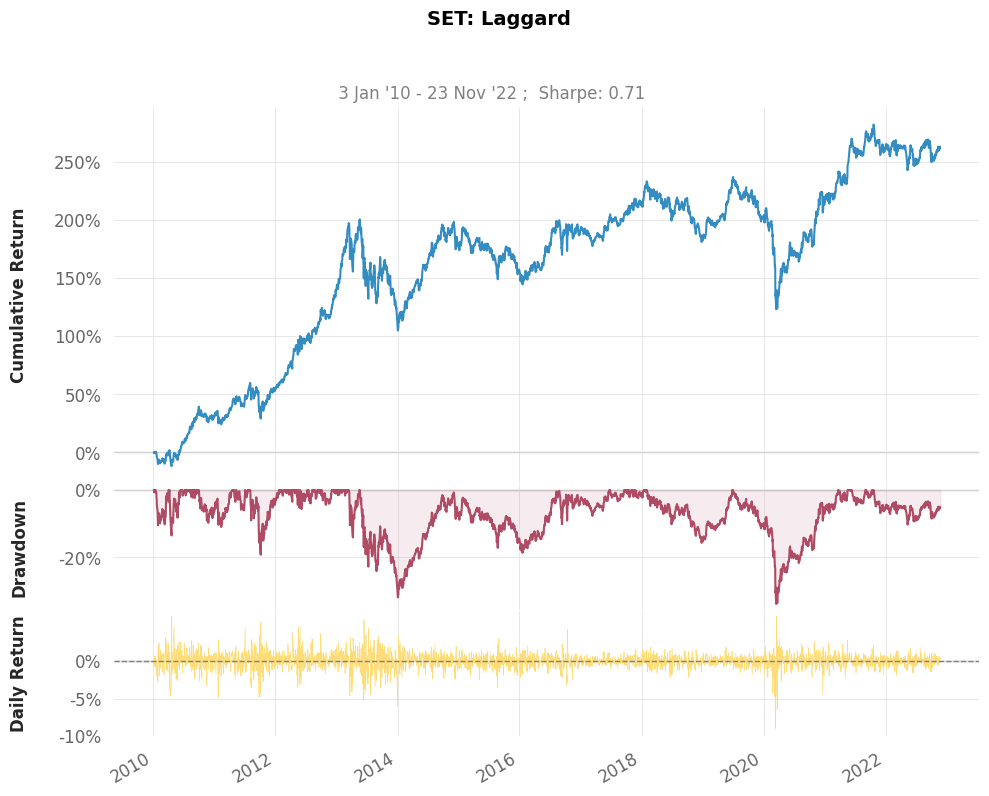

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   263.11%     121.83%
CAGR﹪              10.52%      6.37%

Sharpe              0.71        0.47
Prob. Sharpe Ratio  99.35%      95.09%
Sortino             1.0         0.65
Sortino/√2          0.71        0.46
Omega               1.14        1.14

Max Drawdown        -33.77%     -44.29%
Longest DD Days     1493        1763

Gain/Pain Ratio     0.14        0.09
Gain/Pain (1M)      0.81        0.44

Payoff Ratio        0.95        0.91
Profit Factor       1.14        1.09
Common Sense Ratio  1.16        1.06
CPC Index           0.57        0.53
Tail Ratio          1.02        0.97
Outlier Win Ratio   3.63        3.89
Outlier Loss Ratio  4.11        4.12

MTD                 2.01%       0.97%
3M         

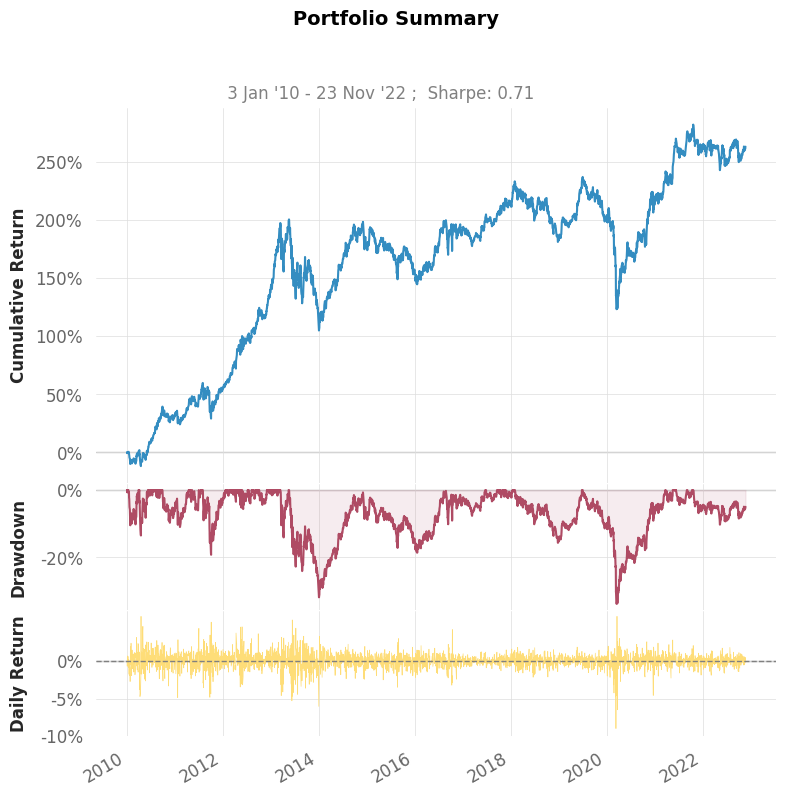

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


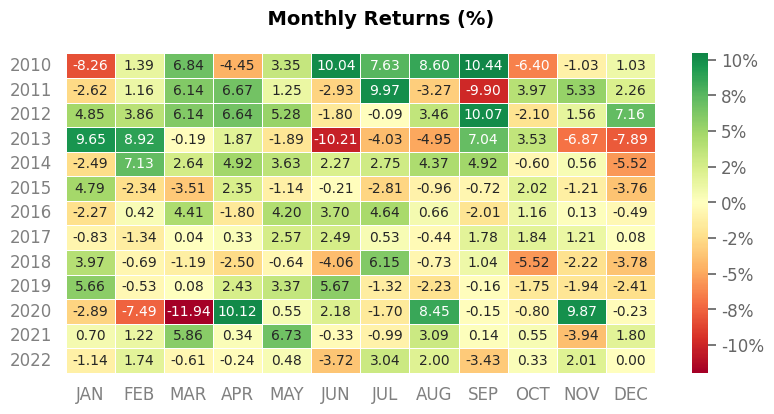

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET100

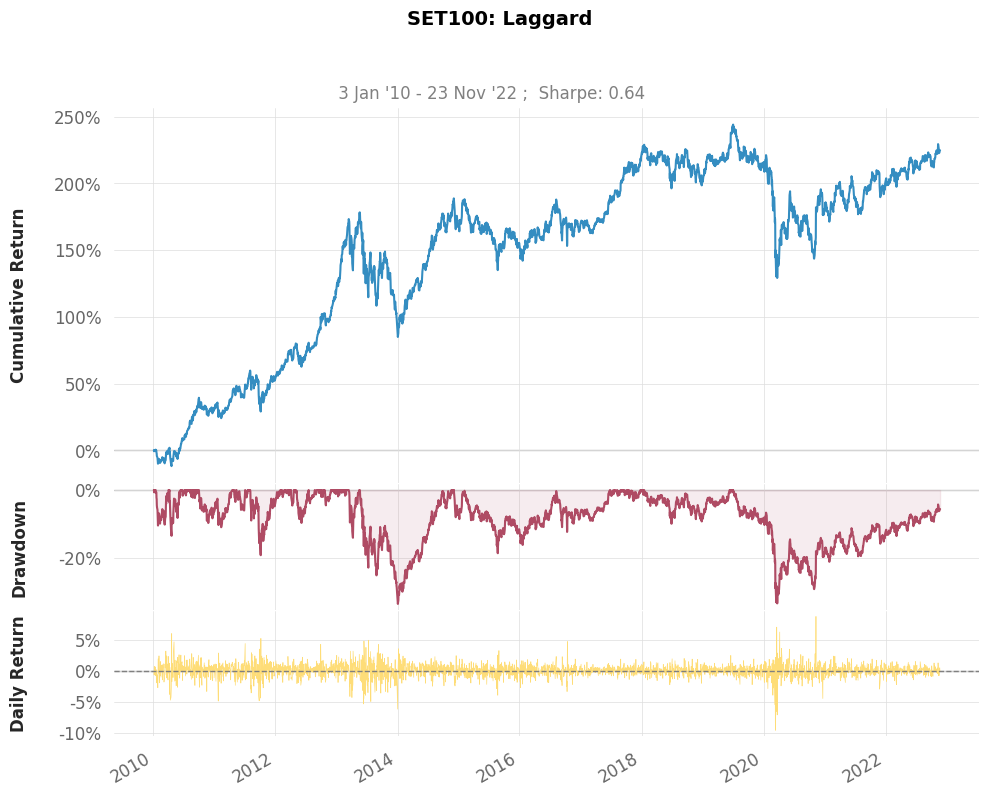

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   224.82%     121.83%
CAGR﹪              9.57%       6.37%

Sharpe              0.64        0.47
Prob. Sharpe Ratio  98.69%      95.09%
Sortino             0.9         0.65
Sortino/√2          0.63        0.46
Omega               1.12        1.12

Max Drawdown        -33.54%     -44.29%
Longest DD Days     1238        1763

Gain/Pain Ratio     0.12        0.09
Gain/Pain (1M)      0.65        0.44

Payoff Ratio        0.94        0.91
Profit Factor       1.12        1.09
Common Sense Ratio  1.15        1.06
CPC Index           0.56        0.53
Tail Ratio          1.02        0.97
Outlier Win Ratio   3.51        3.88
Outlier Loss Ratio  3.97        4.2

MTD                 0.54%       0.97%
3M          

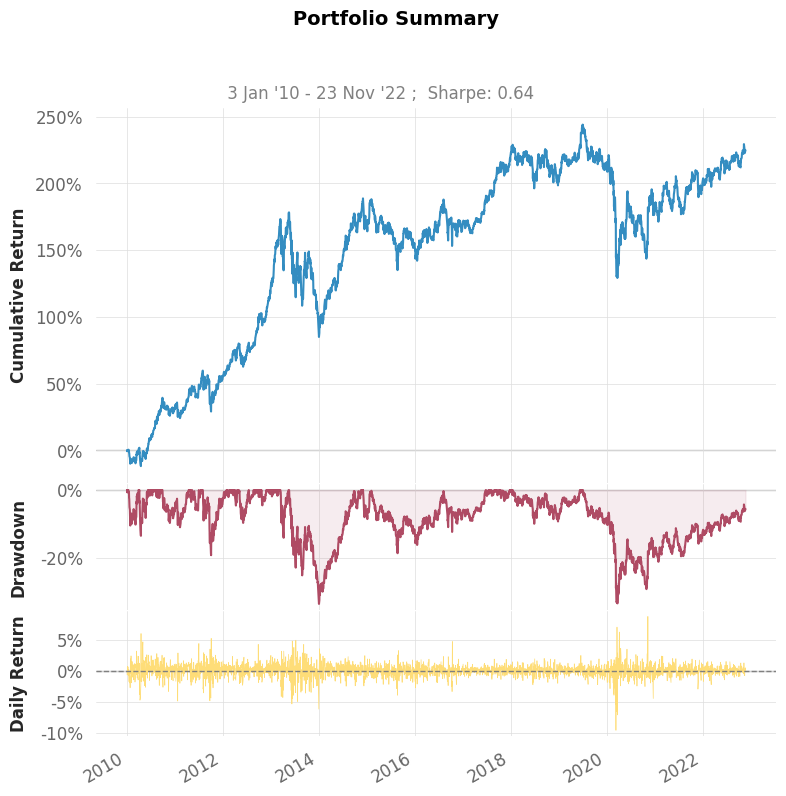

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


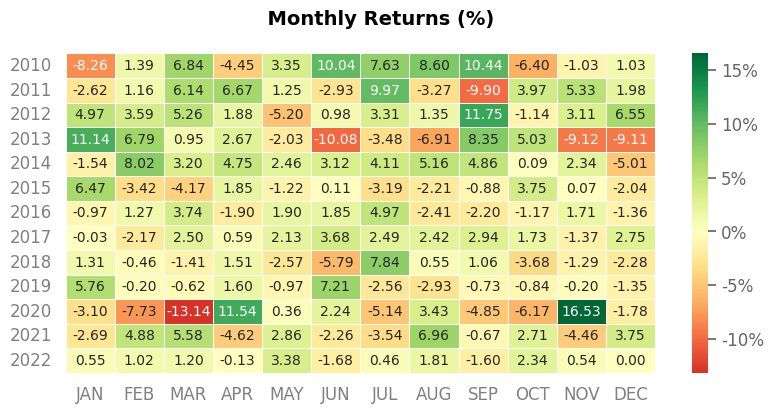

In [ ]:
MODEL_NAME = "Laggard"
UNIVERSE = ["SET100"]
ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

close_df = ssc.get_data(field="close", timeframe="daily")
value_df = ssc.get_data(field="value", timeframe="daily")

pct30d_df = ssc.ta.roc(close_df, 30)
# roa
roa_q_df = ssc.get_data(field="roa", timeframe="quarterly")  # roa_q > 0
roa_y_df = ssc.get_data(
    field="roa", timeframe="yearly"
)  # roa current year > roa previous year
roa_y_s1_df = ssc.get_data(field="roa", timeframe="yearly", shift=1)

# cfo
cfo_df = ssc.get_data(field="net_operating", timeframe="quarterly")  # cfo > 0
np_df = ssc.get_data(field="net_profit", timeframe="quarterly")  # cfo > net_profit

# de
de_df = ssc.get_data(
    field="de", timeframe="yearly"
)  # (de current year / de previous year - 1) < 0
de_s1_df = ssc.get_data(field="de", timeframe="yearly", shift=1)

# current ratio
current_ratio_df = ssc.get_data(
    field="current_ratio", timeframe="yearly"
)  # (ct current year / ct previous year - 1) > 0
current_ratio_s1_df = ssc.get_data(field="current_ratio", timeframe="yearly", shift=1)

# gross profit margin
gpm_df = ssc.get_data(
    field="gross_profit_margin", timeframe="yearly"
)  # (gpm current year / gpm previos year 1) > 0
gpm_s1_df = ssc.get_data(field="gross_profit_margin", timeframe="yearly", shift=1)

# ไม่มีการเพิ่มทุน
cap_paidin_df = ssc.get_data(
    field="cap_paidin", timeframe="yearly"
)  # (cap_paidin_df - cap_paidin_s1_df) == 0
cap_paidin_s1_df = ssc.get_data(field="cap_paidin", timeframe="yearly", shift=1)

# asset turnover
ato_df = ssc.get_data(
    field="asset_turnover", timeframe="yearly"
)  # ato current year > ato previos year
ato_s1_df = ssc.get_data(field="asset_turnover", timeframe="yearly", shift=1)
# screening condition
# 1. roa_q > 0
roq_q_cond = (roa_q_df > 0).astype(int)
# 2. roa current year > roa previous year
roa_y_cond = (roa_y_df > roa_y_s1_df).astype(int)
# 3. cfo > 0
cfo_cond = (cfo_df > 0).astype(int)
# 4. cfo > net_profit
cfo_net_cond = (cfo_df > np_df).astype(int)
# 5.(de current year / de previous year - 1) < 0
de_cond = ((de_df / de_s1_df - 1) < 0).astype(int)
# 6. (ct current year / ct previous year - 1) > 0
current_ratio_cond = ((current_ratio_df / current_ratio_s1_df - 1) > 0).astype(int)
# 7. gpm current year > gpm previos year
gpm_cond = ((gpm_df / gpm_s1_df - 1) > 0).astype(int)
# 8. capital paid in are not change
cap_paidin_cond = ((cap_paidin_df - cap_paidin_s1_df) == 0).astype(int)
# 9. ato current year > ato previos year
ato_cond = (ato_df > ato_s1_df).astype(int)

# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

# combine scoring
f_score = (
    roq_q_cond
    + roa_y_cond
    + cfo_cond
    + cfo_net_cond
    + de_cond
    + current_ratio_cond
    + gpm_cond
    + cap_paidin_cond
    + ato_cond
)
signal_cond = (f_score >= 6) & (pct30d_df < 4.6) & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)


def screen_pct30d_df(signal_df: pd.DataFrame, pct30d_df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), pct30d_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )


# pct30d change
# 10 highest pct30d change (but less than 4.6)
screen_pct30d_df = screen_pct30d_df(signal_df, pct30d_df)
rank_pct30d_df = ssc.rank(factor_df=screen_pct30d_df, quantity=10, ascending=False)
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (rank_pct30d_df > 0) & (rank_pct30d_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET50

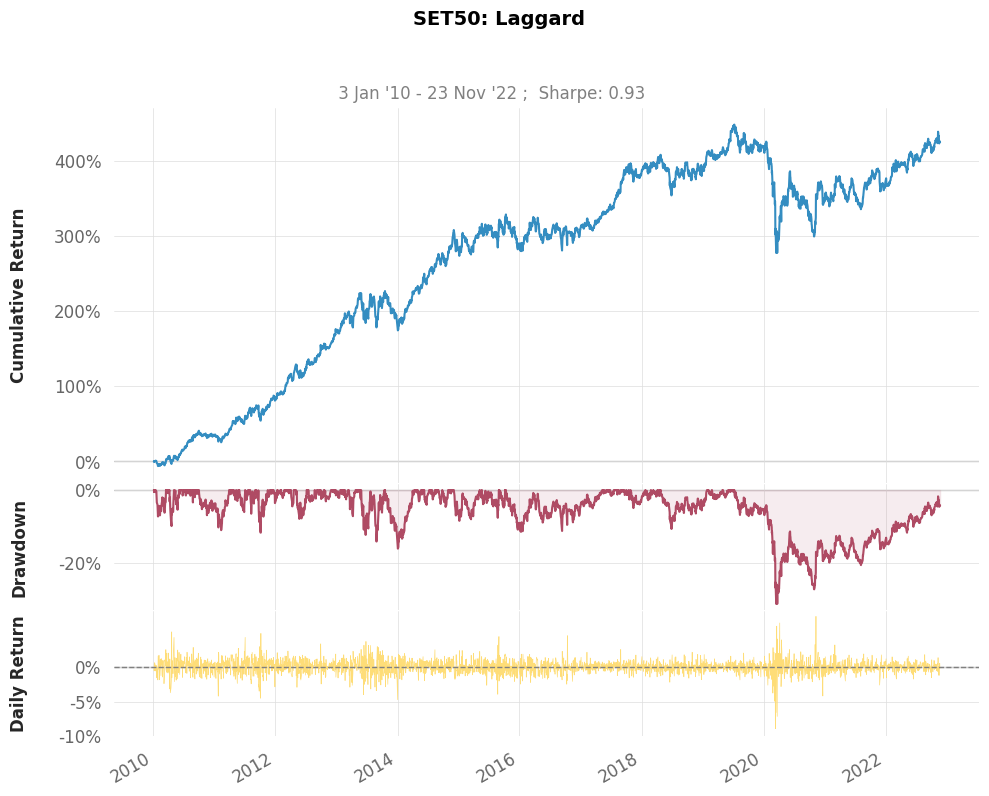

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   425.24%     121.83%
CAGR﹪              13.73%      6.37%

Sharpe              0.93        0.47
Prob. Sharpe Ratio  99.94%      95.09%
Sortino             1.35        0.65
Sortino/√2          0.96        0.46
Omega               1.18        1.18

Max Drawdown        -31.16%     -44.29%
Longest DD Days     1231        1763

Gain/Pain Ratio     0.18        0.09
Gain/Pain (1M)      1.16        0.44

Payoff Ratio        0.98        0.9
Profit Factor       1.18        1.09
Common Sense Ratio  1.25        1.06
CPC Index           0.62        0.53
Tail Ratio          1.06        0.97
Outlier Win Ratio   3.53        3.68
Outlier Loss Ratio  3.88        3.73

MTD                 -0.63%      0.97%
3M          

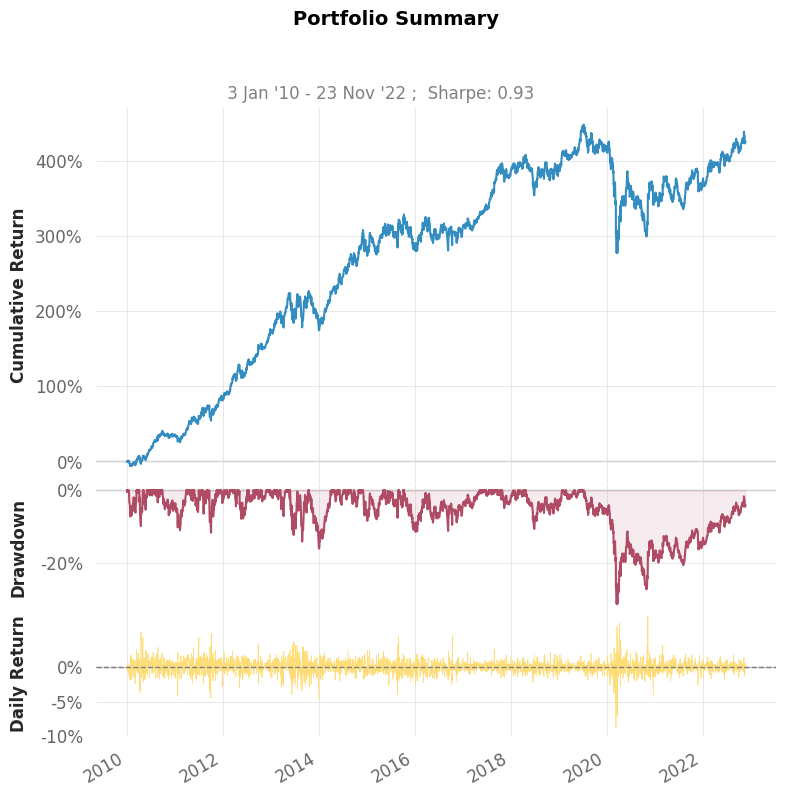

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


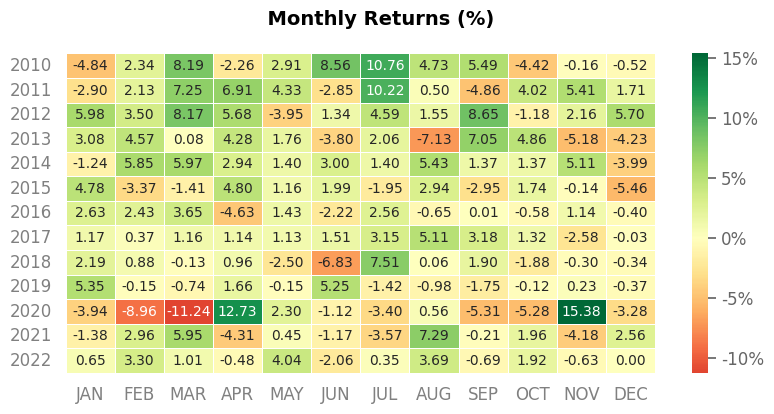

In [ ]:
MODEL_NAME = "Laggard"
UNIVERSE = ["SET50"]
ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

close_df = ssc.get_data(field="close", timeframe="daily")
value_df = ssc.get_data(field="value", timeframe="daily")

pct30d_df = ssc.ta.roc(close_df, 30)
# roa
roa_q_df = ssc.get_data(field="roa", timeframe="quarterly")  # roa_q > 0
roa_y_df = ssc.get_data(
    field="roa", timeframe="yearly"
)  # roa current year > roa previous year
roa_y_s1_df = ssc.get_data(field="roa", timeframe="yearly", shift=1)

# cfo
cfo_df = ssc.get_data(field="net_operating", timeframe="quarterly")  # cfo > 0
np_df = ssc.get_data(field="net_profit", timeframe="quarterly")  # cfo > net_profit

# de
de_df = ssc.get_data(
    field="de", timeframe="yearly"
)  # (de current year / de previous year - 1) < 0
de_s1_df = ssc.get_data(field="de", timeframe="yearly", shift=1)

# current ratio
current_ratio_df = ssc.get_data(
    field="current_ratio", timeframe="yearly"
)  # (ct current year / ct previous year - 1) > 0
current_ratio_s1_df = ssc.get_data(field="current_ratio", timeframe="yearly", shift=1)

# gross profit margin
gpm_df = ssc.get_data(
    field="gross_profit_margin", timeframe="yearly"
)  # (gpm current year / gpm previos year 1) > 0
gpm_s1_df = ssc.get_data(field="gross_profit_margin", timeframe="yearly", shift=1)

# ไม่มีการเพิ่มทุน
cap_paidin_df = ssc.get_data(
    field="cap_paidin", timeframe="yearly"
)  # (cap_paidin_df - cap_paidin_s1_df) == 0
cap_paidin_s1_df = ssc.get_data(field="cap_paidin", timeframe="yearly", shift=1)

# asset turnover
ato_df = ssc.get_data(
    field="asset_turnover", timeframe="yearly"
)  # ato current year > ato previos year
ato_s1_df = ssc.get_data(field="asset_turnover", timeframe="yearly", shift=1)
# screening condition
# 1. roa_q > 0
roq_q_cond = (roa_q_df > 0).astype(int)
# 2. roa current year > roa previous year
roa_y_cond = (roa_y_df > roa_y_s1_df).astype(int)
# 3. cfo > 0
cfo_cond = (cfo_df > 0).astype(int)
# 4. cfo > net_profit
cfo_net_cond = (cfo_df > np_df).astype(int)
# 5.(de current year / de previous year - 1) < 0
de_cond = ((de_df / de_s1_df - 1) < 0).astype(int)
# 6. (ct current year / ct previous year - 1) > 0
current_ratio_cond = ((current_ratio_df / current_ratio_s1_df - 1) > 0).astype(int)
# 7. gpm current year > gpm previos year
gpm_cond = ((gpm_df / gpm_s1_df - 1) > 0).astype(int)
# 8. capital paid in are not change
cap_paidin_cond = ((cap_paidin_df - cap_paidin_s1_df) == 0).astype(int)
# 9. ato current year > ato previos year
ato_cond = (ato_df > ato_s1_df).astype(int)

# volume > 2e7
value_cond = value_df.rolling(window=20).mean() > 2e7

# combine scoring
f_score = (
    roq_q_cond
    + roa_y_cond
    + cfo_cond
    + cfo_net_cond
    + de_cond
    + current_ratio_cond
    + gpm_cond
    + cap_paidin_cond
    + ato_cond
)
signal_cond = (f_score >= 6) & (pct30d_df < 4.6) & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)


def screen_pct30d_df(signal_df: pd.DataFrame, pct30d_df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), pct30d_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )


# pct30d change
# 10 highest pct30d change (but less than 4.6)
screen_pct30d_df = screen_pct30d_df(signal_df, pct30d_df)
rank_pct30d_df = ssc.rank(factor_df=screen_pct30d_df, quantity=10, ascending=False)

from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (rank_pct30d_df > 0) & (rank_pct30d_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)
## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])